Required Dependencies

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import ee
import xarray as xr


import utils

from utils.ground_stations import plot_stations_folium
from utils.helpers import get_region_geojson
from utils.CHIRPS_helpers import get_chirps_pentad_gee
from utils.plotting import plot_xarray_data

%matplotlib inline

## Data Extraction
- Accesssing TAHMO Data and CHIRPS Data

###  Extract TAHMO data using filter-stations

Documentation: https://filter-stations.netlify.app/

A config file is provided with the api keys to access TAHMO Data
```json
{
    "apiKey": "",
    "apiSecret": "",
}

```

In [7]:
import json
from utils.filter_stations import RetrieveData

# Load the config file
with open('config.json', 'r') as f:
    config = json.load(f)

# Set the api key and secret
api_key = config['apiKey']
api_secret = config['apiSecret']


# Initialize the class
rd = RetrieveData(apiKey=api_key, 
                  apiSecret=api_secret)

East Africa: April-May 2025 floods (Kenya/Rwanda/Uganda), where heavy rains overwhelmed stations.


In [6]:
# get Kenyan TAHMO weather stations
ke_stations = rd.get_stations_info(countrycode='KE')
print(f"Number of stations in Kenya: {len(ke_stations)}")

# Rwandan Stations
rw_stations = rd.get_stations_info(countrycode='RW')
print(f"Number of stations in Rwanda: {len(rw_stations)}")

# Ugandan Stations
ug_stations = rd.get_stations_info(countrycode='UG')
print(f"Number of stations in Uganda: {len(ug_stations)}")

# Concatenate the East African stations
eac_stations = pd.concat([ke_stations, rw_stations, ug_stations])
print(f"Total number of stations in East Africa: {len(eac_stations)}")

Number of stations in Kenya: 180
Number of stations in Rwanda: 19
Number of stations in Uganda: 61
Total number of stations in East Africa: 260


In [4]:
# Plot the stations on a map
plot_stations_folium([ke_stations, rw_stations, ug_stations],
                     colors=["blue", "red", "green"])

In [5]:
# create the data directory/ground for the ground observations
os.makedirs("data/ground", exist_ok=True)

# save this data to be reused later
eac_stations.to_csv("data/ground/eac_stations.csv", index=False)

In [6]:
# Extract the precipitation data for the East African stations (April -May 2025)
start_date = "2025-04-01"
end_date = "2025-05-31"

eac_precip = rd.multiple_measurements(stations_list=eac_stations['code'].tolist(),
                                     startDate=start_date,
                                     endDate=end_date,
                                     variables=['pr'],
                                     csv_file = "data/ground/eac_precip_apr_may_2025.csv")


Retrieving data for stations:   0%|          | 0/260 [00:00<?, ?it/s]

An error occurred: None: Max retries exceeded with url: /services/measurements/v2/stations/TA00024/measurements/controlled?start=2025-04-01T00%3A00%3A00Z&end=2025-05-31T00%3A00%3A00Z&variable=pr (Caused by None)


### Extracting CHIRPS data

Extract the data from Google Earth engine project
Set up Google Earth Engine Project to access and extract the data


#### Steps to setting up Google Earth Engine Project

1. Get started from the link https://code.earthengine.google.com/register
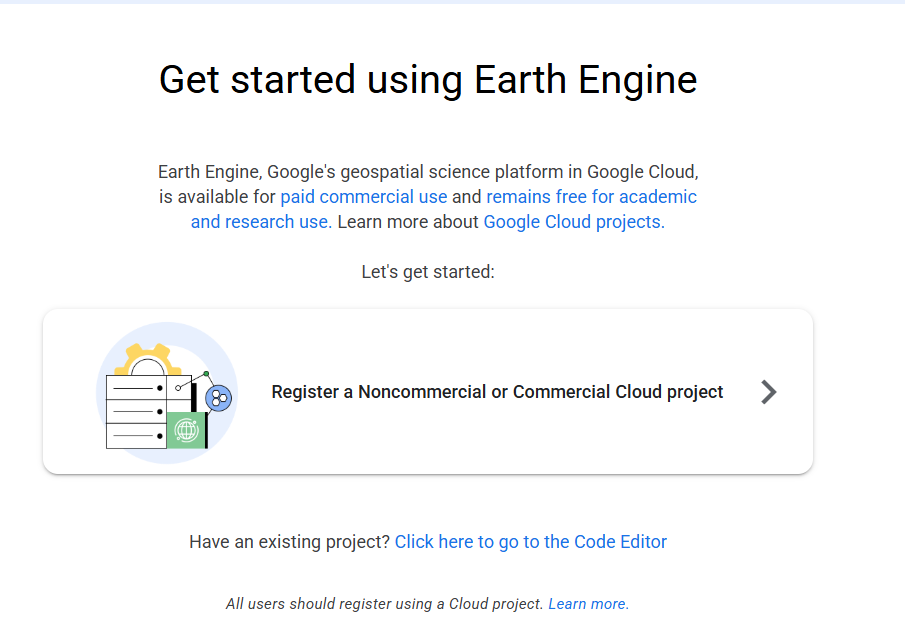

2. 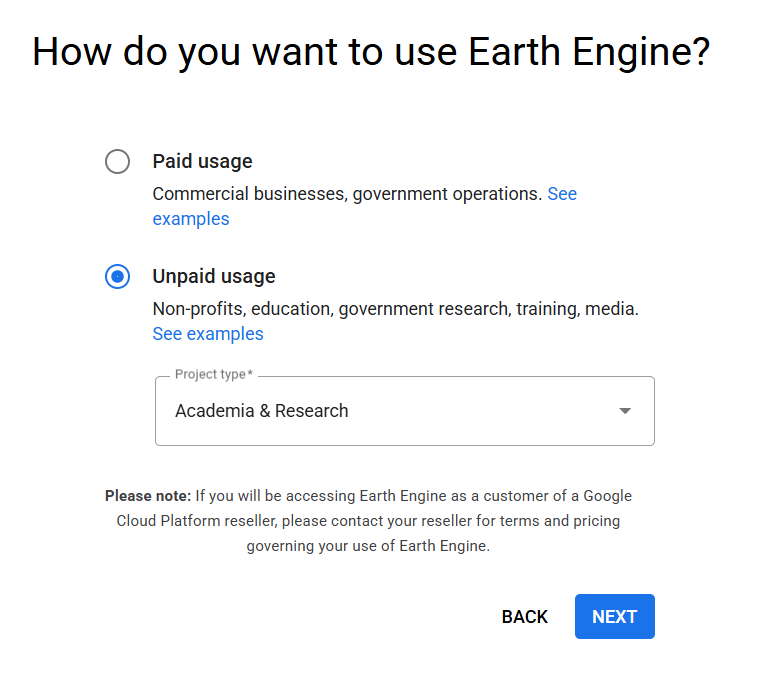

4. 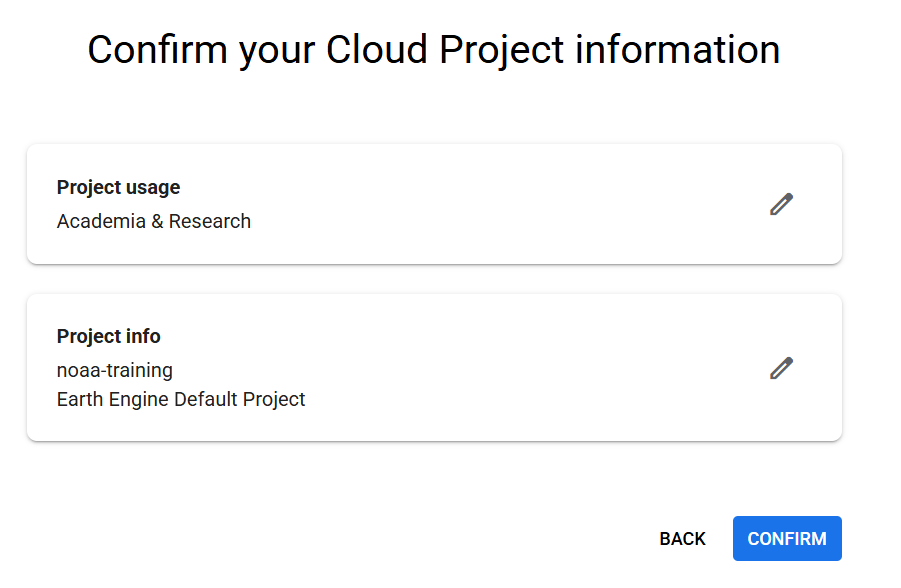

### Extracting CHIRPS Data for the Eat Africa Region (Kenya, Uganda, Rwanda)

Bounding box for the region = 
```
[]
```

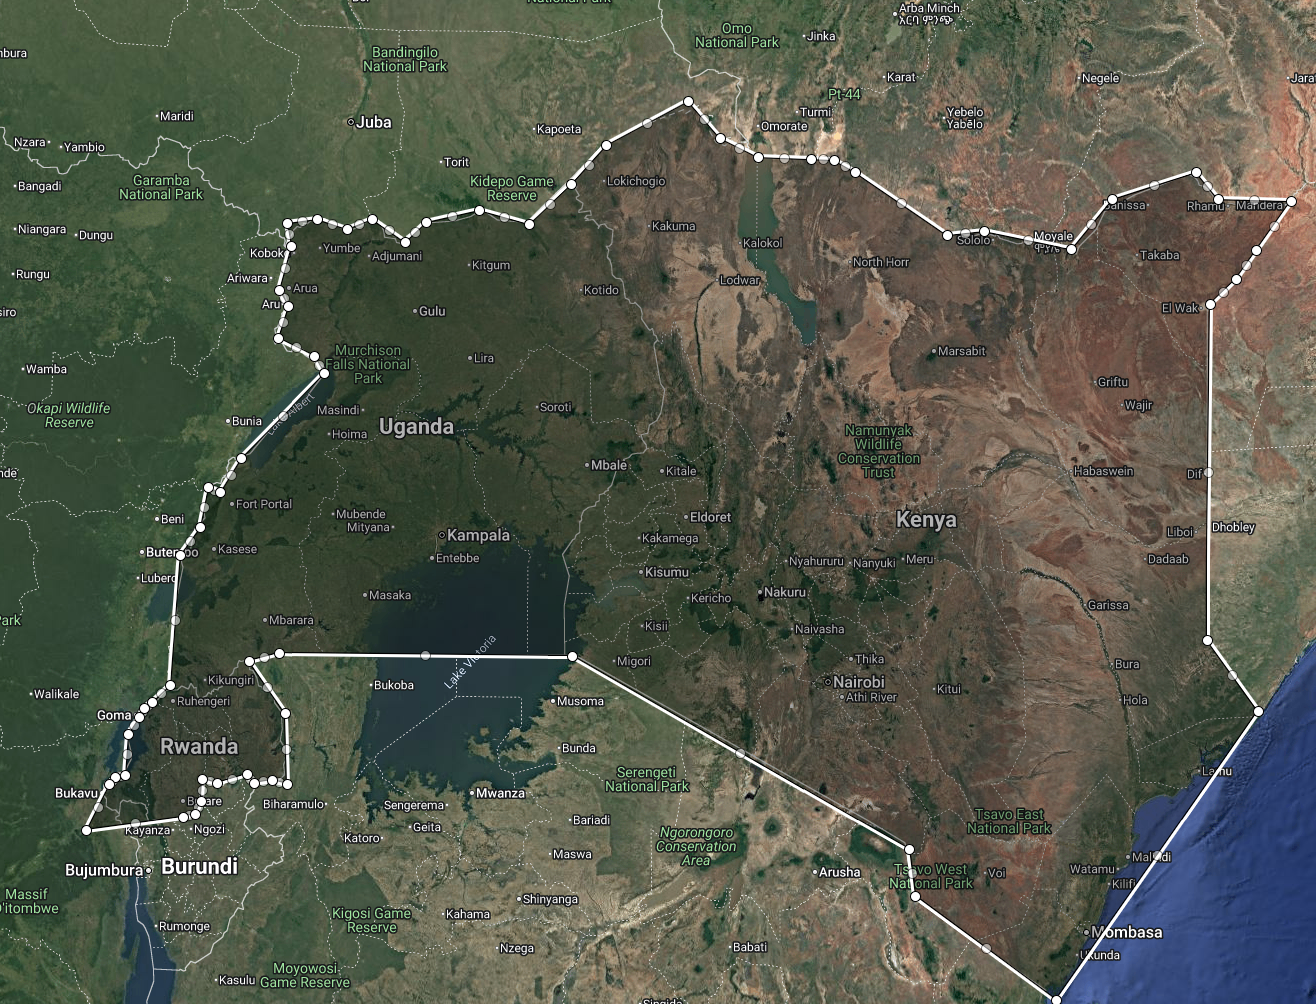

In [8]:
kenya_region = get_region_geojson('Kenya', config['location_key'])['geometry']['coordinates'][0]
uganda_region = get_region_geojson('Uganda', config['location_key'])['geometry']['coordinates'][0]
rwanda_region = get_region_geojson('Rwanda', config['location_key'])['geometry']['coordinates'][0]

# EAC region to be the sum of this polygon
eac_region = kenya_region + uganda_region + rwanda_region
sorted(eac_region)

[[28.861754, -2.8399383],
 [28.861754, -2.8399383],
 [28.861754, -1.0473752],
 [29.573433, -1.4823178],
 [29.573433, -1.4823178],
 [29.573433, 4.218628],
 [30.8991179, -2.8399383],
 [30.8991179, -1.0473752],
 [33.90982109999999, -4.724299999999999],
 [33.90982109999999, -4.724299999999999],
 [33.90982109999999, 5.033420899999999],
 [35.0330489, -1.4823178],
 [35.0330489, 4.218628],
 [41.9068688, -4.724299999999999],
 [41.9068688, 5.033420899999999]]

In [15]:

ee.Authenticate()
ee.Initialize(project='leafy-computing-310902')

# Define region of interest (Kenya)
roi = ee.Geometry.Polygon(eac_region)

# Make directory to save satellite data
os.makedirs("data/satellite", exist_ok=True)

# Extract data for 2020
ds = get_chirps_pentad_gee(
    start_date="2025-04-01", 
    end_date="2025-05-31", 
    region=roi,
    export_path='data/satellite/chirps_pentad_eac.nc'
)

print(ds)

Total number of images: 12

Exporting 1/12: chirps_temp\20250401.tif
Generating URL ...
Please wait ...
Data downloaded to d:\previous-pc\Agent\TAHMO\workshops\NOAA-workshop\chirps_temp\20250401.tif


Exporting 2/12: chirps_temp\20250406.tif
Generating URL ...
Please wait ...
Data downloaded to d:\previous-pc\Agent\TAHMO\workshops\NOAA-workshop\chirps_temp\20250406.tif


Exporting 3/12: chirps_temp\20250411.tif
Generating URL ...
Please wait ...
Data downloaded to d:\previous-pc\Agent\TAHMO\workshops\NOAA-workshop\chirps_temp\20250411.tif


Exporting 4/12: chirps_temp\20250416.tif
Generating URL ...
Please wait ...
Data downloaded to d:\previous-pc\Agent\TAHMO\workshops\NOAA-workshop\chirps_temp\20250416.tif


Exporting 5/12: chirps_temp\20250421.tif
Generating URL ...
Please wait ...
Data downloaded to d:\previous-pc\Agent\TAHMO\workshops\NOAA-workshop\chirps_temp\20250421.tif


Exporting 6/12: chirps_temp\20250426.tif
Generating URL ...
Please wait ...
Data downloaded to d:\previous-

In [21]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:        (time: 12, y: 198, x: 265)
Coordinates:
  * x              (x) float64 2kB 28.87 28.92 28.97 29.02 ... 41.81 41.86 41.91
  * y              (y) float64 2kB 5.015 4.965 4.916 ... -4.62 -4.669 -4.719
  * time           (time) datetime64[ns] 96B 2025-04-01 ... 2025-05-26
    spatial_ref    int64 8B 0
Data variables:
    precipitation  (time, y, x) float32 3MB dask.array<chunksize=(1, 198, 256), meta=np.ndarray>

In [23]:
ds = ds.where(ds != -9999)

In [24]:
ds.precipitation.sel(x=41.5, y=-5.3, method="nearest").to_pandas()

time
2025-04-01   NaN
2025-04-06   NaN
2025-04-11   NaN
2025-04-16   NaN
2025-04-21   NaN
2025-04-26   NaN
2025-05-01   NaN
2025-05-06   NaN
2025-05-11   NaN
2025-05-16   NaN
2025-05-21   NaN
2025-05-26   NaN
Name: precipitation, dtype: float32

In [25]:
# Select a single time and the (only) band to obtain a 2D array (y, x) for plotting
# pentad_da = ds.band_data.isel(time=0, band=0).squeeze()

# Wrap back into a dataset so the plotting helper expecting a dataset+column works
# pentad_ds = pentad_da.to_dataset(name='band_data')

plot_xarray_data(
    ds,
    column='precipitation',
    fig_title='CHIRPS Pentad Precipitation (mm)\n(Pentad starting {})'.format(str(ds.time.values[0])[:10]),
    polygon=eac_region
)

## Data Processing
1. Range, missing, and flatline detection (≥ N days with unchanged values).
2. Aggregate station rain to pentads to match CHIRPS.
3. Nearest-pixel extraction from CHIRPS and merge with station pentads.
4. Compute per-station Pearson r, RMSE, completeness, outlier rate, paired t-test for
bias.
5. Combine into a 0–100 confidence score and classify (High/Medium/Low).

In [41]:
# Load the CHIRPS and station data
import xarray as xr

eac_data = pd.read_csv("data\ground\eac_precip_apr_may_2025.csv.csv")
# eac metadata
eac_metadata = pd.read_csv("data/ground/eac_stations.csv")

# CHIRPS Xarray dataset
chirps_ds = xr.open_dataset("data/satellite/chirps_pentad_eac.nc")

Format CHIRPS Data

In [42]:
chirps_ds = chirps_ds.where(chirps_ds != -9999)
chirps_ds.precipitation.sel(x=41.5, y=-5.3, method="nearest").to_pandas()

time
2025-04-01   NaN
2025-04-06   NaN
2025-04-11   NaN
2025-04-16   NaN
2025-04-21   NaN
2025-04-26   NaN
2025-05-01   NaN
2025-05-06   NaN
2025-05-11   NaN
2025-05-16   NaN
2025-05-21   NaN
2025-05-26   NaN
Name: precipitation, dtype: float32

Format the TAHMO Data

In [43]:
# Rename Unnamed columns
eac_data = eac_data.rename(columns={"Unnamed: 0": "Date"})
# set Date as datetime
eac_data['Date'] = pd.to_datetime(eac_data['Date'])
# set as index
eac_data = eac_data.set_index('Date')
# localize to None
eac_data.index = eac_data.index.tz_localize(None)

### 1. Range, missing, and flatline detection (≥ N days with unchanged values).

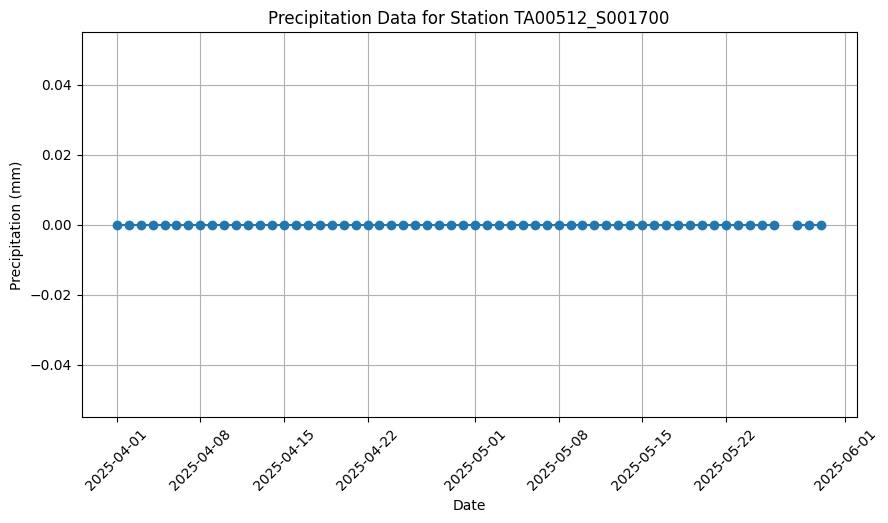

Station Code: TA00512_S001700
Data Range: 0.0 mm to 0.0 mm
Number of Records: 61


In [56]:
# Check the range of the data and plot any of the stations randomly
def plot_stations_data_randomly(eac_data):
    import random
    station_codes = eac_data.columns.to_list()
    random_station = random.choice(station_codes)
    station_data = eac_data[random_station]
    
    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, marker='o')
    plt.title(f'Precipitation Data for Station {random_station}')
    plt.xlabel('Date')
    
    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.show()
    
    print(f"Station Code: {random_station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")
    
plot_stations_data_randomly(eac_data)

Stations with missing data: ['TA00022', 'TA00023', 'TA00024', 'TA00025_S000116', 'TA00025_S002904', 'TA00025_S002905', 'TA00027', 'TA00028', 'TA00031', 'TA00062', 'TA00063', 'TA00065', 'TA00069', 'TA00070_S000768', 'TA00070_S002354', 'TA00074', 'TA00078', 'TA00129', 'TA00133', 'TA00134', 'TA00146', 'TA00147', 'TA00155', 'TA00158', 'TA00166', 'TA00171_S002981', 'TA00173_S000398', 'TA00173_S001569', 'TA00178', 'TA00186', 'TA00188', 'TA00190', 'TA00250', 'TA00258', 'TA00274_S001428', 'TA00274_S002982', 'TA00274_S002983', 'TA00281', 'TA00307', 'TA00320', 'TA00356', 'TA00359', 'TA00378', 'TA00386', 'TA00387', 'TA00389', 'TA00394', 'TA00416', 'TA00441', 'TA00448', 'TA00469', 'TA00569', 'TA00587', 'TA00622', 'TA00623', 'TA00624', 'TA00625', 'TA00626', 'TA00627', 'TA00628', 'TA00629', 'TA00630', 'TA00631', 'TA00632', 'TA00677', 'TA00678', 'TA00765', 'TA00766', 'TA00770', 'TA00771', 'TA00772', 'TA00773', 'TA00774', 'TA00775', 'TA00778', 'TA00807', 'TA00809', 'TA00811', 'TA00824', 'TA00825', 'TA

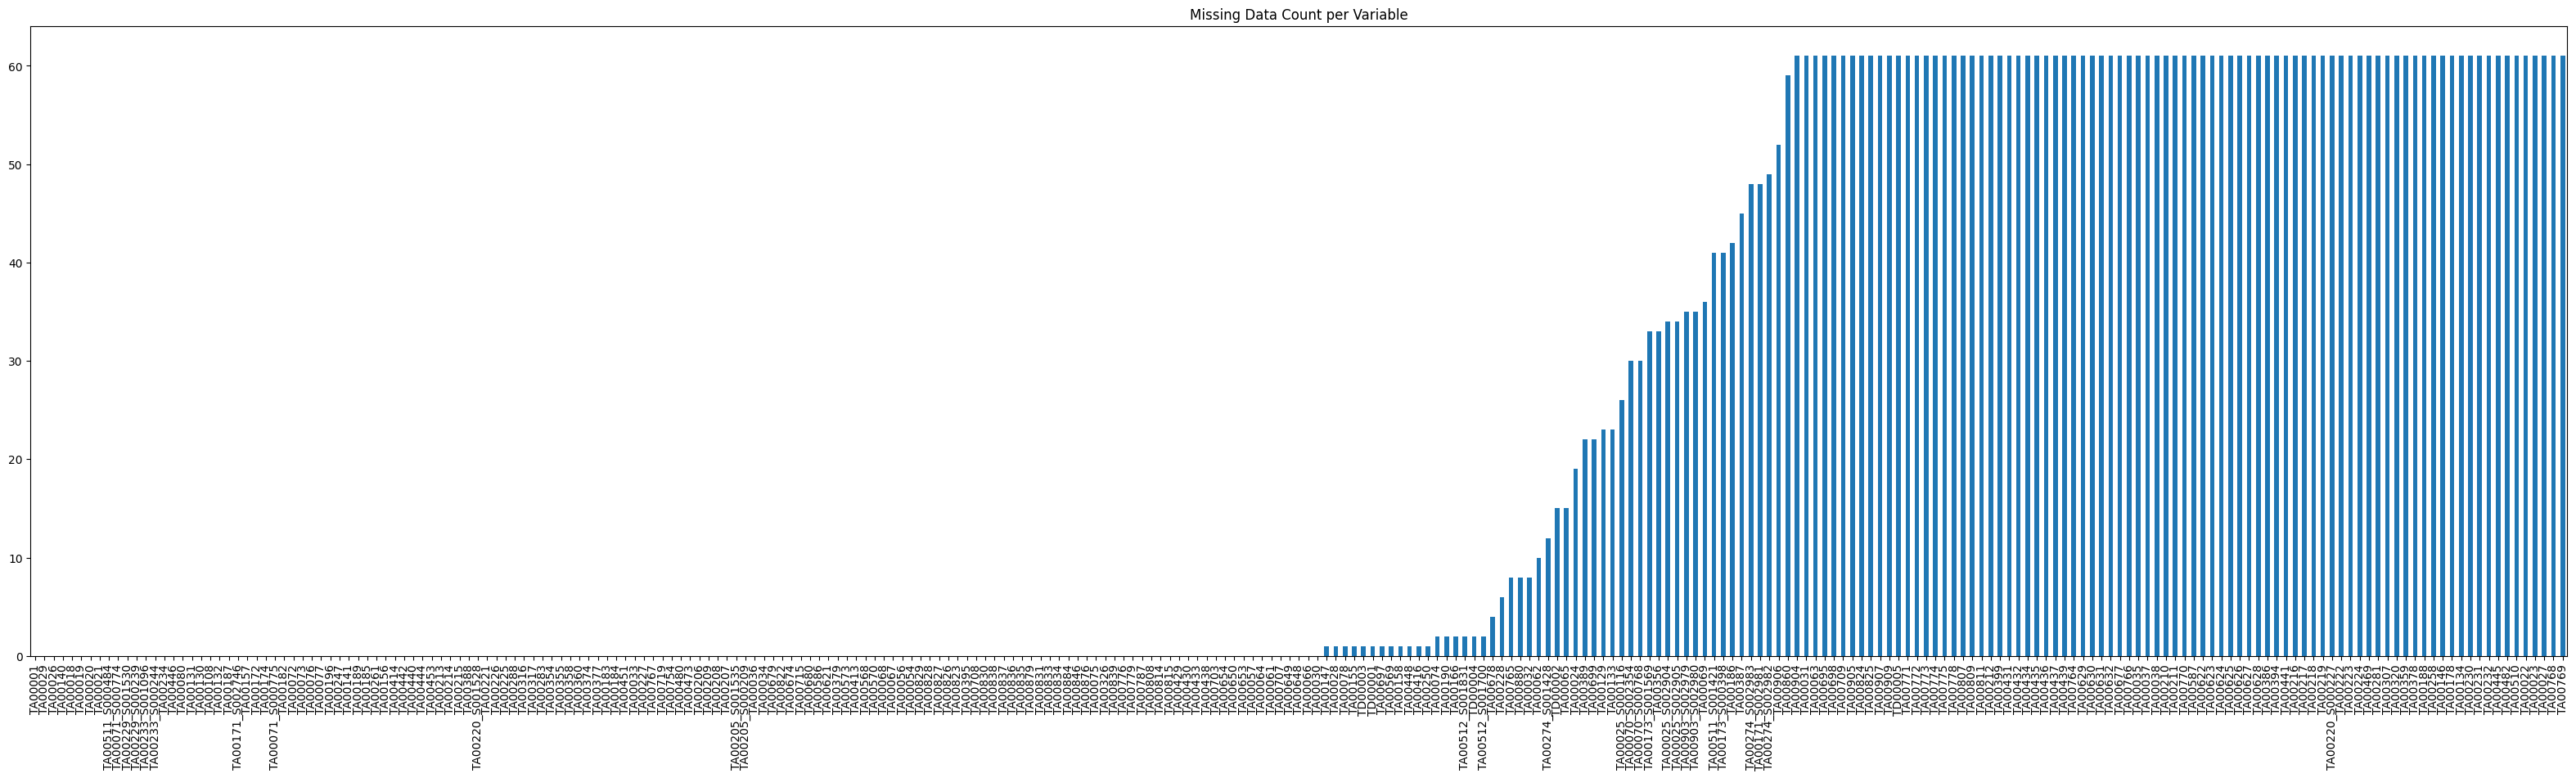

In [68]:
eac_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# Get the stations with missing data
missing_stations = eac_data.columns[eac_data.isna().any()].tolist()
print(f"Stations with missing data: {missing_stations}")


Stations with missing data: ['TA00024', 'TA00025_S000116', 'TA00025_S002904', 'TA00025_S002905', 'TA00028', 'TA00062', 'TA00065', 'TA00069', 'TA00070_S000768', 'TA00070_S002354', 'TA00074', 'TA00078', 'TA00129', 'TA00133', 'TA00147', 'TA00155', 'TA00158', 'TA00166', 'TA00171_S002981', 'TA00173_S000398', 'TA00173_S001569', 'TA00186', 'TA00190', 'TA00250', 'TA00274_S001428', 'TA00274_S002982', 'TA00274_S002983', 'TA00356', 'TA00387', 'TA00389', 'TA00416', 'TA00448', 'TA00569', 'TA00678', 'TA00765', 'TA00880', 'TA00903_S002980', 'TA00903_S002979', 'TD00001', 'TD00002', 'TD00004', 'TA00906', 'TD00003', 'TA00032', 'TA00228', 'TA00511_S001421', 'TA00512_S001700', 'TA00512_S001831', 'TA00697', 'TA00699', 'TA00860']


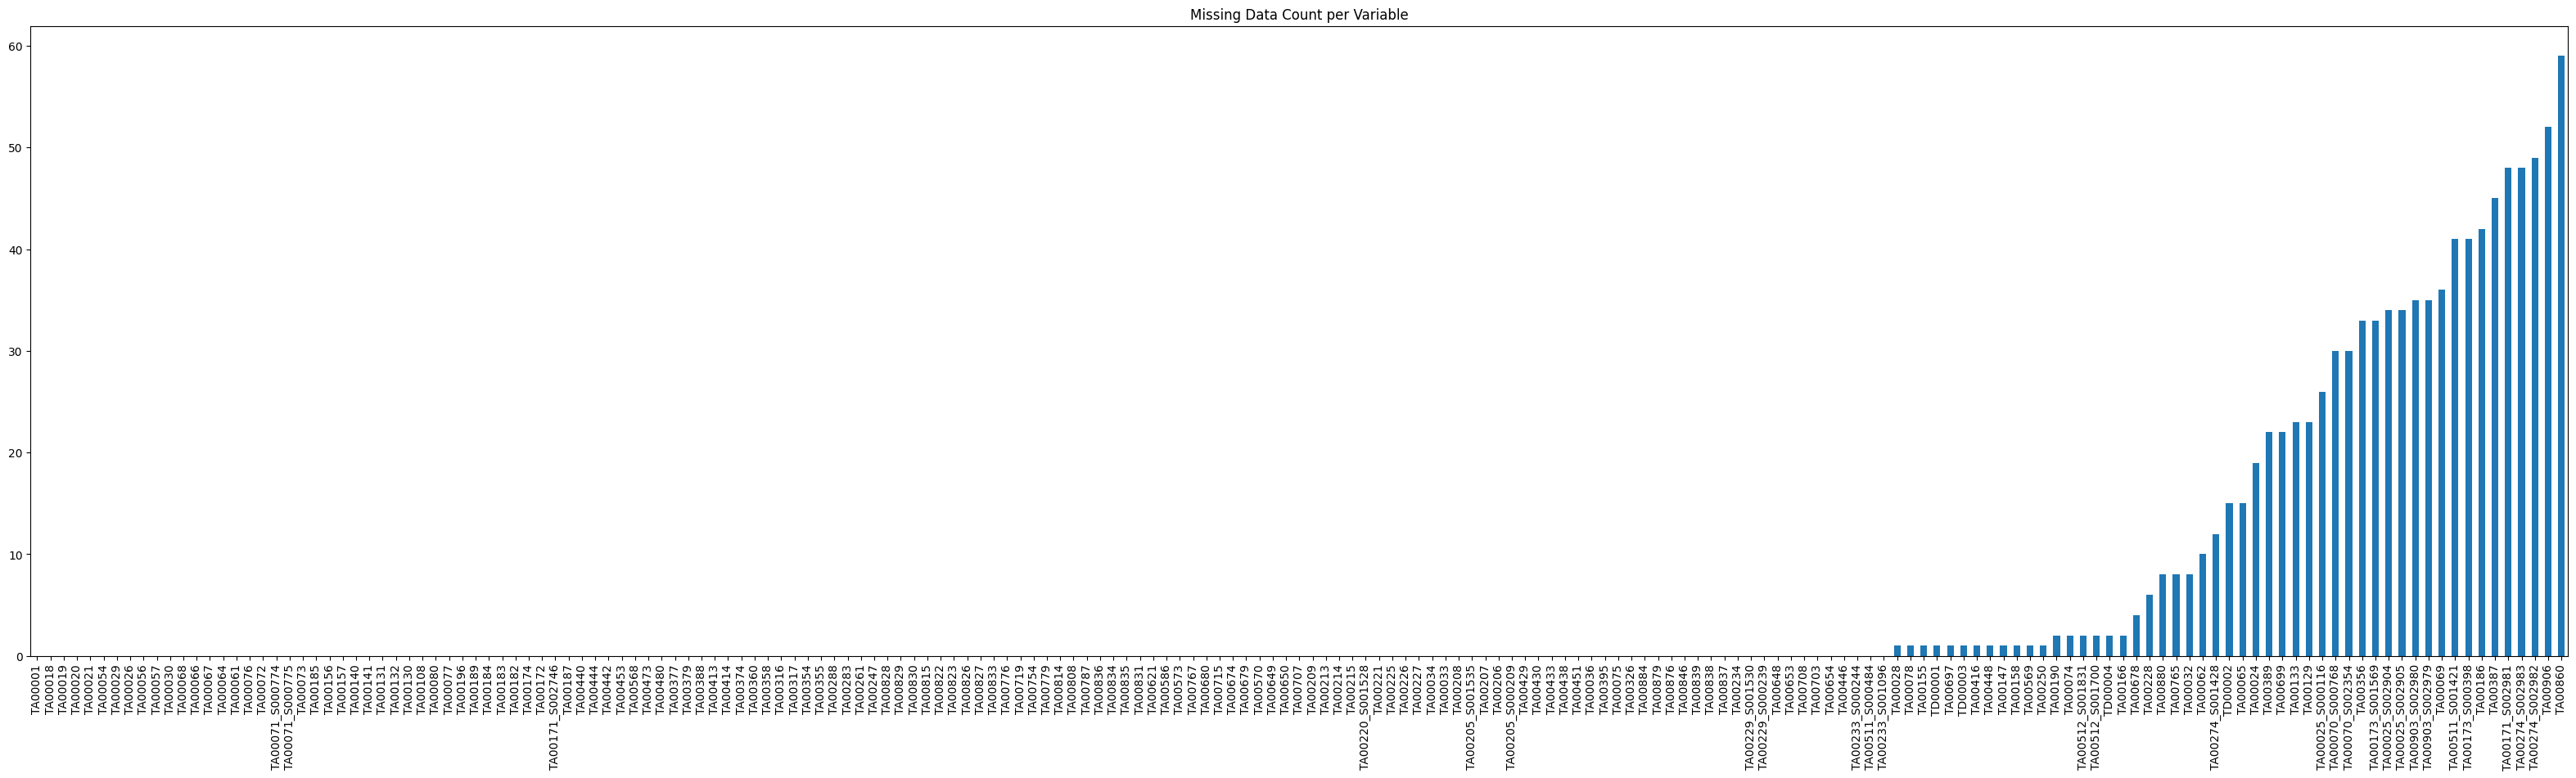

In [69]:
# drop stations with all missing data
eac_data = eac_data.dropna(how='all', axis=1)
eac_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# Get the stations with missing data
missing_stations = eac_data.columns[eac_data.isna().any()].tolist()
print(f"Stations with missing data: {missing_stations}")

Stations with missing data: ['TA00024', 'TA00028', 'TA00062', 'TA00065', 'TA00069', 'TA00074', 'TA00078', 'TA00129', 'TA00133', 'TA00147', 'TA00155', 'TA00158', 'TA00166', 'TA00186', 'TA00190', 'TA00250', 'TA00356', 'TA00387', 'TA00389', 'TA00416', 'TA00448', 'TA00569', 'TA00678', 'TA00765', 'TA00880', 'TD00001', 'TD00002', 'TD00004', 'TA00906', 'TD00003', 'TA00032', 'TA00228', 'TA00697', 'TA00699', 'TA00860']


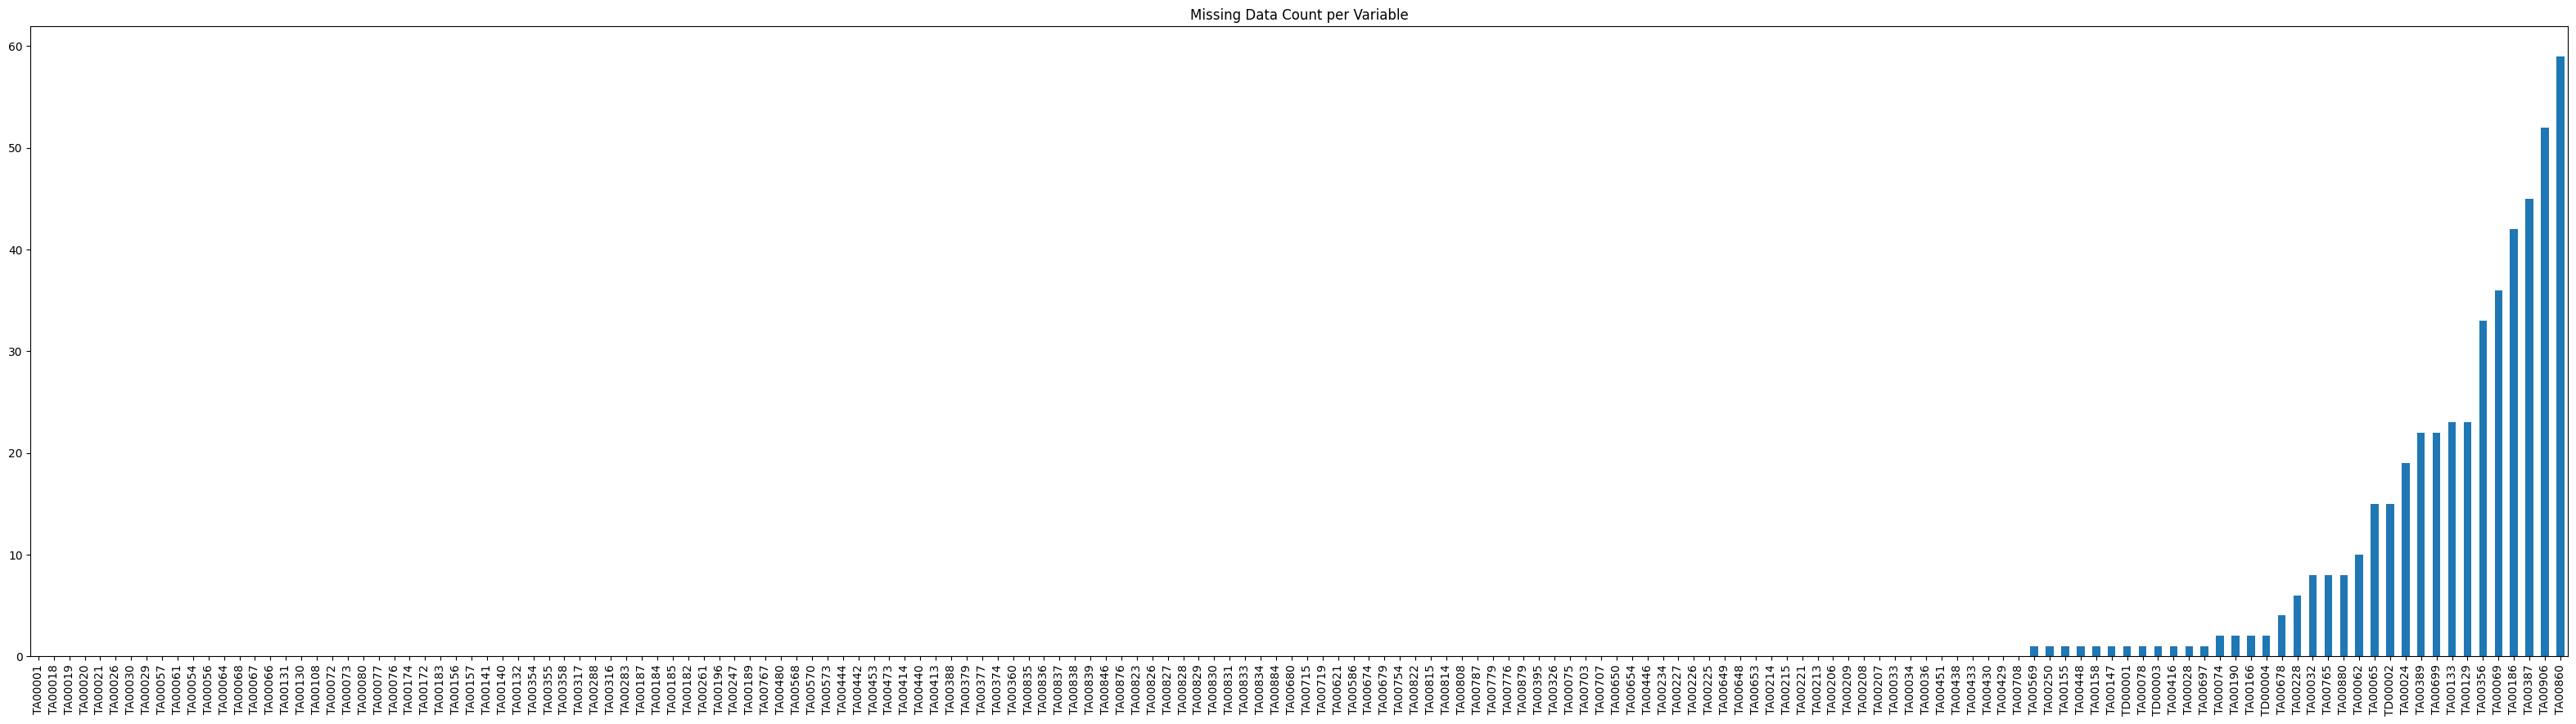

In [71]:
# Drop stations with multiple sensors station_sensor columns
multiple_sensors = [i for i in eac_data.columns if len(i.split('_')) > 1]
eac_data = eac_data.drop(columns=multiple_sensors)
eac_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# Get the stations with missing data
missing_stations = eac_data.columns[eac_data.isna().any()].tolist()
print(f"Stations with missing data: {missing_stations}")


In [74]:
eac_data.TA00001.rolling(window=5).std()

Date
2025-04-01         NaN
2025-04-02         NaN
2025-04-03         NaN
2025-04-04         NaN
2025-04-05    0.027849
                ...   
2025-05-27    0.041537
2025-05-28    0.041720
2025-05-29    0.043820
2025-05-30    0.007970
2025-05-31    0.000698
Name: TA00001, Length: 61, dtype: float64

In [75]:
# Check for flatlines when values do not change for k days (k=5) with a rolling window
def detect_flatlines(data, window_size=5):
    # store the station and the window in a dictionary
    flatline_info = {}
    for station in data.columns:
        rolling_std = data[station].rolling(window=window_size).std()
        flatline_periods = rolling_std[rolling_std == 0].index.tolist()
        if flatline_periods:
            flatline_info[station] = flatline_periods
    return flatline_info
flatlines = detect_flatlines(eac_data, window_size=5)
print(f"Stations with flatlines: {flatlines}")

Stations with flatlines: {'TA00028': [Timestamp('2025-04-15 00:00:00')], 'TA00030': [Timestamp('2025-04-16 00:00:00'), Timestamp('2025-04-17 00:00:00'), Timestamp('2025-04-18 00:00:00'), Timestamp('2025-05-04 00:00:00')], 'TA00057': [Timestamp('2025-05-01 00:00:00')], 'TA00067': [Timestamp('2025-04-14 00:00:00'), Timestamp('2025-04-15 00:00:00'), Timestamp('2025-04-16 00:00:00'), Timestamp('2025-04-17 00:00:00'), Timestamp('2025-04-18 00:00:00'), Timestamp('2025-04-19 00:00:00'), Timestamp('2025-04-20 00:00:00'), Timestamp('2025-05-16 00:00:00'), Timestamp('2025-05-17 00:00:00'), Timestamp('2025-05-18 00:00:00'), Timestamp('2025-05-19 00:00:00'), Timestamp('2025-05-20 00:00:00'), Timestamp('2025-05-21 00:00:00'), Timestamp('2025-05-22 00:00:00'), Timestamp('2025-05-23 00:00:00'), Timestamp('2025-05-24 00:00:00'), Timestamp('2025-05-25 00:00:00'), Timestamp('2025-05-26 00:00:00'), Timestamp('2025-05-27 00:00:00'), Timestamp('2025-05-28 00:00:00'), Timestamp('2025-05-29 00:00:00'), Times

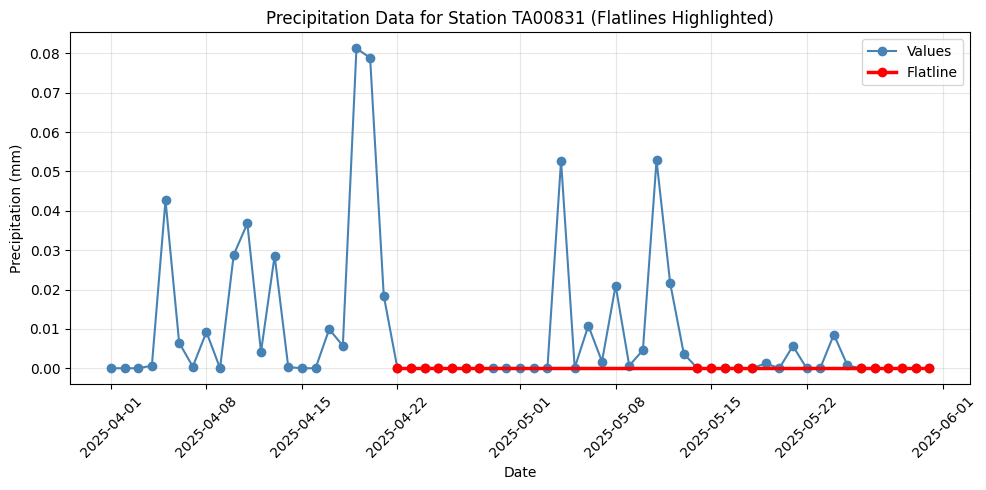

Station Code: TA00831
Data Range: 0.0 mm to 0.0812743055555555 mm
Number of Records: 61
Flatline window end timestamps (window=5):
  - 2025-04-26 00:00:00
  - 2025-04-27 00:00:00
  - 2025-04-28 00:00:00
  - 2025-05-18 00:00:00
  - 2025-05-30 00:00:00
  - 2025-05-31 00:00:00


In [88]:
# plot the flatline stations highlighting flatline periods in red
def plot_flatline_stations(data, flatline_info, window_size=5, random=True):
    import random
    
    if not flatline_info:
        print("No flatlines detected.")
        return
    
    station = random.choice(list(flatline_info.keys())) if random else list(flatline_info.keys())[0]
    station_data = data[station].copy()
    
    # Build a mask for flatline periods
    mask = pd.Series(False, index=station_data.index)
    periods = flatline_info[station]
    for end_ts in periods:
        if end_ts in station_data.index:
            # mark the window contributing to zero std
            start_pos = station_data.index.get_loc(end_ts) - window_size + 1
            if start_pos >= 0:
                flat_index = station_data.index[start_pos: station_data.index.get_loc(end_ts) + 1]
                mask.loc[flat_index] = True
    
    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, color='steelblue', marker='o', label='Values')
    
    # Overlay flatline segments in red
    if mask.any():
        flat_series = station_data[mask]
        # To keep contiguous red segments joined, plot as line over masked points sorted
        plt.plot(flat_series.index, flat_series.values, color='red', linewidth=2.5, marker='o', label='Flatline')
    
    plt.title(f'Precipitation Data for Station {station} (Flatlines Highlighted)')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Station Code: {station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")
    if periods:
        print(f"Flatline window end timestamps (window={window_size}):")
        for ts in periods:
            print(f"  - {ts}")
    else:
        print("No flatline periods for this station.")

plot_flatline_stations(eac_data, flatlines, window_size=5, random=True)

In [91]:
eac_pentad = rd.aggregate_variables(eac_data, freq='5D')[:-1]

In [ ]:
eac_metadata[eac_metadata.code == 'TA00001']

0      TA00001
1      TA00018
2      TA00019
3      TA00020
4      TA00021
        ...   
255    TA00768
256    TA00769
257    TA00860
258    TA00904
259    TA00905
Name: code, Length: 260, dtype: object

Build CHIRPS Nearest Data